In [13]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

## Example: 2 Qubits

Let's first have a look at the case of Grover's algorithm for $N=4$ which is realized with 2 qubits. Say we want to find $\lvert \omega \rangle = \lvert 11 \rangle$

### Step 1: initialization
We start by preparing a quantum circuit with two qubits.

In [6]:
n = 2
grover_circuit = QuantumCircuit(n)

First, we need to initialize the state $|s\rangle$. Let's create a general function (for any number of qubits):

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

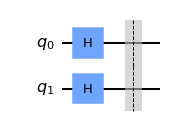

In [7]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.barrier()
grover_circuit.draw()

### Step 2: Oracle
Let's look at the case $\lvert w \rangle = \lvert 11 \rangle$. The oracle $U_\omega$ in this case acts as follows: 

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

or:

$$
U_\omega = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

which you may recognise as the controlled-Z gate. Thus, for this example, our oracle is simply the controlled-Z gate.

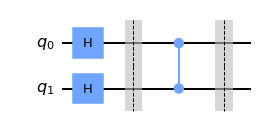

In [8]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.barrier()
grover_circuit.draw()

### Step 3: Diffuser

In order to complete the circuit we need to implement the additional reflection $U_s = 2|s\rangle\langle s| - \mathbb{1}$. Since this is a reflection about $|s\rangle$, we want to add a negative phase to every state orthogonal to $|s\rangle$. 

One way we can do this is to use the operation that transforms the state $|s\rangle \rightarrow |0\rangle$, which we already know is the Hadamard gate applied to each qubit:

$$H^{\otimes n}|s\rangle = |0\rangle$$

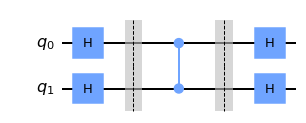

In [9]:
grover_circuit.h([0,1])
grover_circuit.draw()

Then we apply a circuit that adds a negative phase to the states orthogonal to $|0\rangle$:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

i.e. the signs of each state are flipped except for $\lvert 00 \rangle$.

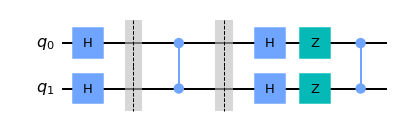

In [10]:
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.draw()

Finally, we do the operation that transforms the state $|0\rangle \rightarrow |s\rangle$ (the H-gate again):

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

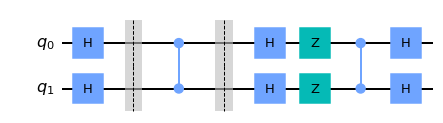

In [11]:
grover_circuit.h([0,1])
grover_circuit.draw()

In this particular case, only <b>one rotation</b> is required to rotate the initial state $|s\rangle$ to the winner $|w\rangle$:
<ol>
    <li>
        Following  the above introduction, in the case $N=4$ we have 

$$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

</li>
<li>
        After $t$ steps, we have $$(U_s U_\omega)^t  | s \rangle = \sin \theta_t | \omega \rangle + \cos \theta_t | s' \rangle ,$$where $$\theta_t = (2t+1)\theta.$$
</li>
<li>
        In order to obtain $| \omega \rangle$ we need $\theta_t = \frac{\pi}{2}$, which with $\theta=\frac{\pi}{6}$ inserted above results to $t=1$. This implies that after $t=1$ rotation the searched element is found.

### Experiments using simulators
First, we can verify that we have the correct statevector

In [14]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_circuit)
result = sv_sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

Next, do it on the qasm simulator

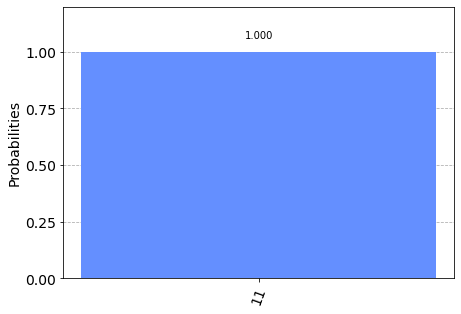

In [15]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_circuit)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

## (Bonus) Solving Sudoku using Grover's Algorithm

The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

#### (Note: you might need to toggle the upper/lower case of ".png" to correctly display the image below)

<div>
<img src="2x2.png" width="200"/>
</div>

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical [decision problems](https://en.wikipedia.org/wiki/Decision_problem) into oracles for Grover's algorithm.

### Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution. Similar to how we created a classical adder using quantum circuits in [_The Atoms of Computation_](https://qiskit.org/textbook/ch-states/atoms-computation.html), we simply need to create a _classical_ function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [17]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. To check these clauses computationally, we will use the `XOR` gate (we came across this in the atoms of computation).

In [18]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

The `output0` bit in the circuit below will only be flipped if `input0 ≠ input1`:

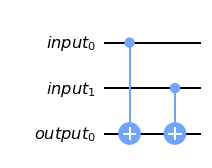

In [19]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

This circuit checks whether `input0 == input1` and stores the output to `output0`. To check each clause, we repeat this circuit for each pairing in `clause_list` and store the output to a new bit:

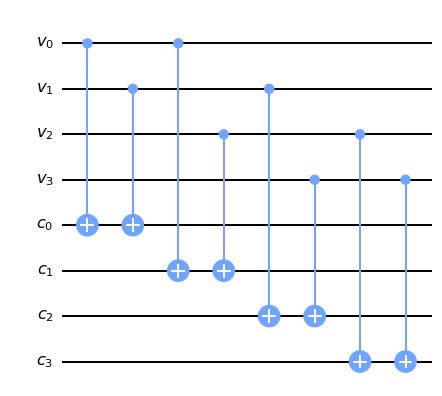

In [20]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

The final state of the bits `c0, c1, c2, c3` will only all be `1` in the case that the assignments of `v0, v1, v2, v3` are a solution to the sudoku. To complete our checking circuit, we want a single bit to be `1` if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

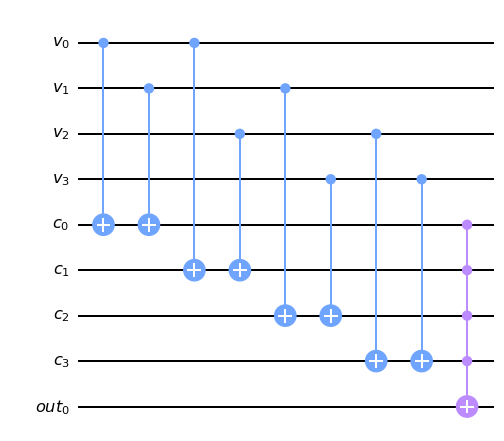

In [21]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

The circuit above takes as input an initial assignment of the bits `v0`, `v1`, `v2` and `v3`, and all other bits should be initialised to `0`. After running the circuit, the state of the `out0` bit tells us if this assignment is a solution or not; `out0 = 0` means the assignment _is not_ a solution, and `out0 = 1` means the assignment _is_ a solution.

### Uncomputing, and Completing the Oracle

We can now turn this checking circuit into a Grover oracle using [phase kickback](https://qiskit.org/textbook/ch-gates/phase-kickback.html). To recap, we have 3 registers: 
- One register which stores our sudoku variables (we'll say $x = v_3, v_2, v_1, v_0$)
- One register that stores our clauses (this starts in the state $|0000\rangle$ which we'll abbreviate to $|0\rangle$)
- And one qubit ($|\text{out}_0\rangle$) that we've been using to store the output of our checking circuit. 

To create an oracle, we need our circuit ($U_\omega$) to perform the transformation:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle
$$

If we set the `out0` qubit to the superposition state $|{-}\rangle$ we have:

$$
\begin{aligned}
U_\omega|x\rangle|0\rangle|{-}\rangle 
&= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)
\end{aligned}
$$

If $f(x) = 0$, then we have the state:

$$
\begin{aligned}
&= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= |x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$


(i.e. no change). But if $f(x) = 1$ (i.e. $x = \omega$), we introduce a negative phase to the $|{-}\rangle$ qubit:

$$
\begin{aligned}
&= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\\
&= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&= -|x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

This is a functioning oracle that uses two auxiliary registers in the state $|0\rangle|{-}\rangle$:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

To adapt our checking circuit into a Grover oracle, we need to guarantee the bits in the second register (`c`) are always returned to the state $|0000\rangle$ after the computation. To do this, we simply repeat the part of the circuit that computes the clauses which guarantees `c0 = c1 = c2 = c3 = 0` after our circuit has run. We call this step _'uncomputation'_.

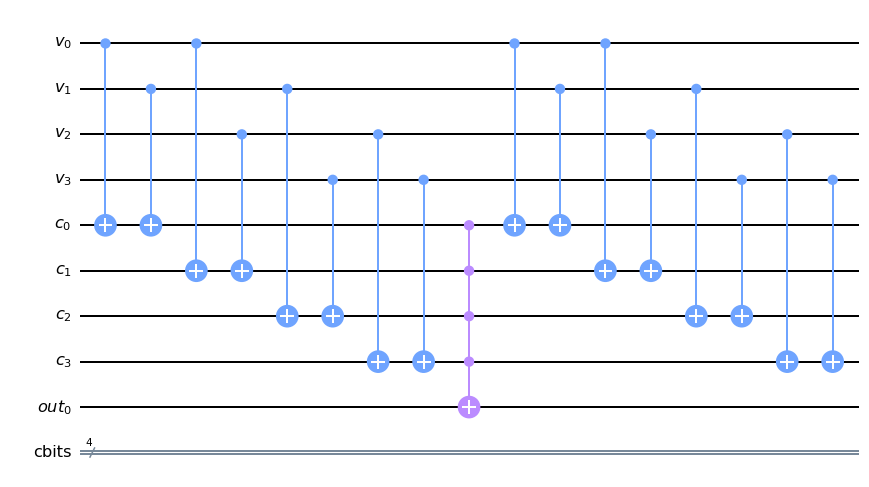

In [22]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

In summary, the circuit above performs:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

and if the initial state of $|\text{out}_0\rangle = |{-}\rangle$,:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

### Setup the Diffuser

Similar to the previous example, we will need to add a diffuser after the oracle. Here we define a generalized diffuser (detailed explaination in Qiskit Textbook).

In [24]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

### The Full Algorithm

All that's left to do now is to put everything together!

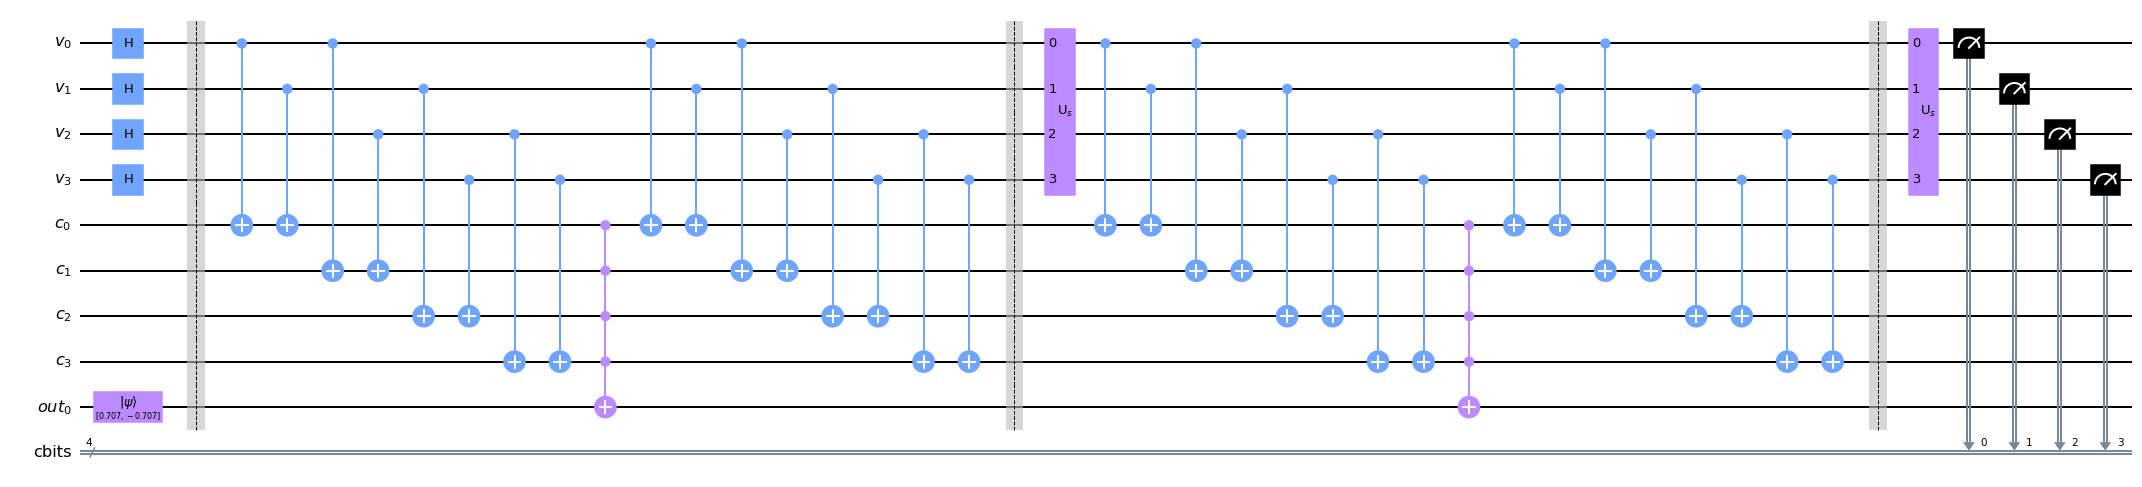

In [42]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialise 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialise qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## Iterations
iterations = 2 # optimal number is 2 (you can try with other numbers, i.e., 1, 3)
for i in range(iterations):
    # Apply our oracle
    sudoku_oracle(qc, clause_list, clause_qubits)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

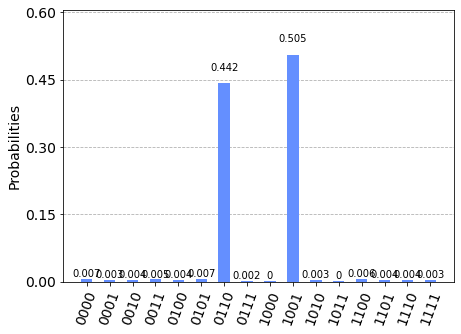

In [43]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
plot_histogram(result.get_counts())

There are two bit strings with a much higher probability of measurement than any of the others, `0110` and `1001`. These correspond to the assignments:
```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```
and
```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```
which are the two solutions to our sudoku! The aim of this section is to show how we can create Grover oracles from real problems. While this specific problem is trivial, the process can be applied (allowing large enough circuits) to any decision problem. To recap, the steps are:

1. Create a reversible classical circuit that identifies a correct solution
2. Use phase kickback and uncomputation to turn this circuit into an oracle
3. Use Grover's algorithm to solve this oracle